# Real-Time Deep Learning Inference for Self-Driving Cars with TensorFlow

## Analysis of Execution Time Statistics of Python, C++ and C++ Real-Time Inferences 


## Background

Deep learning based self driving cars need to make steering and other control decisions at deterministic pace to be able to safely control the behavior of the vehicle in traffic. A car traveling 70 mph moves one feet every 10 ms. One feet can be the difference between successful corrective action and a fatal accident. In this project we analyze the inference execution time determinism and jitter. We compare Python, C++ and real-time optimized C++ deep learning inference implementations for self driving cars using TensorFlow. We expect some jitter and jitter of the order of 5-10 ms is probably acceptable for a self driving car but 50 ms delays probably would be too much for such a critical control system.  

In this project we have created a TensorFlow implementation of the [NVIDIA End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) self driving car model. Our implementation is based on the Python TensorFlow implementation by [Sully Chen](https://github.com/SullyChen/Autopilot-TensorFlow). 

The project consists of a python based training script and a python and two C++ based inference implementations. At the end of the training the training script saves a graph definition where all weights are replaced with corresponding constant values. This saved graph is then loaded by the Python and both C++ inference implementations. 

As the execution environment we used Ubuntu 16.10 with a custom Linux 4.9.13 kernel with a Preempt RT real-time patch. This patch adds hard real-time support to the operating system. The inference was performed on a NVIDIA GTX 1060 GPU.  

In this notebook, we analyze compare the time it takes to perform inference steps for the model using the Python and both C++ based inference implementations. All implementations execute the same TensorFlow graph but it is expected that the Python code has most jitter as it may get impacted by the garbage collection occasionally slowing  down the inference for short periods of time. The regular C++ implementation is also expected to have some jitter, altough less than the Python implementation as C++ doesn't get impacted by grabage collection. The real-time optimized C++ implementation is expected to have least jitter.  

We start by loading the results datasets for inference timing from all of the inference implementations.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

%matplotlib inline  

    # Import run log from CSV file
try:    
    # Python log file
    df_py = pd.DataFrame.from_csv('results/run.py.csv')
    
except: 
    print "Python dataset could not be loaded. Is the dataset missing?"

try:
    # C++ log file
    df_cc = pd.DataFrame.from_csv('results/run.cc.csv')

except: 
    print "C++ dataset could not be loaded. Is the dataset missing?"
    
try:
    # Real-Time C++ log file
    df_rt = pd.DataFrame.from_csv('results/run.rt.csv')
    
except: 
    print "Real-time C++ dataset could not be loaded. Is the dataset missing?"

# Remove two first rows to remove initialization effects
df_py = df_py.loc[df_py.index > 0]
df_cc = df_cc.loc[df_cc.index > 0]
df_rt = df_rt.loc[df_rt.index > 0]

# Select time difference column
dt_py = df_py['Time_Diff']
dt_cc = df_cc['Time_Diff']
dt_rt = df_rt['Time_Diff']

deg_py = df_py['Output']
deg_cc = df_cc['Output']
deg_rt = df_rt['Output']

## Timing Statistics

### Python

Let's first look at the timing statistics of of performing the inference steps. We start with the Python based inference.

In [22]:
display(df_py.describe())

,Time,Time_Diff,Output
count,45566.000000,45566.000000,45566.000000
mean,40.166631,0.001742,0.029094
std,22.791365,0.000401,0.459727
min,0.705414,0.001334,-2.614821
25%,20.518815,0.001607,-0.060713
50%,39.890198,0.001675,0.017185
75%,59.876077,0.001756,0.130217
max,80.072134,0.012324,3.035229


### C++

And below is the timing statistics for the C++ implementation.

In [23]:
display(df_cc.describe())

,Time,Time_Diff,Output
count,45566.000000,45566.000000,45566.000000
mean,37.033648,0.001605,0.029591
std,21.259353,0.000577,0.459447
min,0.683755,0.001075,-2.617980
25%,18.579075,0.001350,-0.060591
50%,36.508150,0.001445,0.017363
75%,56.127175,0.001591,0.131105
max,73.834900,0.013410,3.034520


### Real-Time Optimized C++

And below is the timing statistics for the real-time C++ implementation on Ubuntu with a Preempt RT linux kernel patch.

In [24]:
display(df_rt.describe())

,Time,Time_Diff,Output
count,45566.000000,45566.000000,45566.000000
mean,37.968967,0.001653,0.029591
std,21.652850,0.000742,0.459447
min,0.645837,0.000997,-2.617980
25%,19.692375,0.001212,-0.060591
50%,37.373600,0.001313,0.017363
75%,56.237575,0.001520,0.131105
max,75.946100,0.004809,3.034520


The mean exectution time for the inference steps in the Time_Diff column is nearly identical for all three implementations. The maximum execution time is significantly lower for the real-time optimized C++ implementation than for the regular C++ and Python implementations. 

## Timing Histograms

To get a better understanding of the exection times let's look at the step execution time histograms for both implementations.

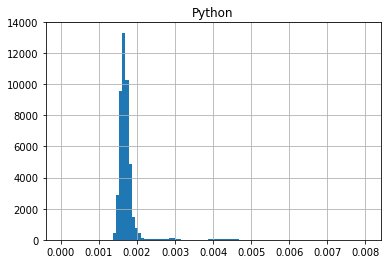

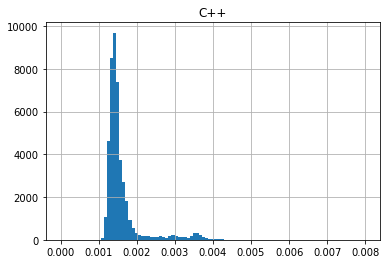

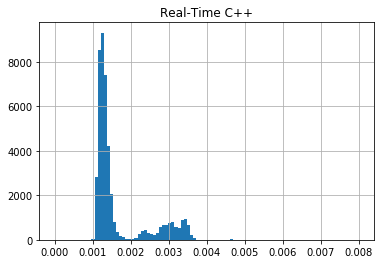

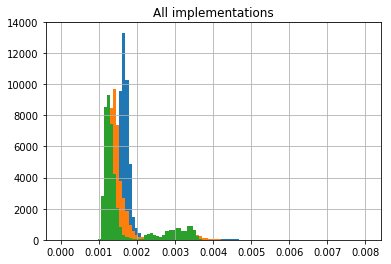

In [25]:
# Figure 1 - Time histograms
bins = np.linspace(0.0,0.008,100)
plt.figure(1)
dt_py.hist(bins=bins)
plt.title('Python')
plt.figure(2)
dt_cc.hist(bins=bins)
plt.title('C++')
plt.figure(3)
dt_rt.hist(bins=bins)
plt.title('Real-Time C++')
plt.figure(4)
dt_py.hist(bins=bins)
dt_cc.hist(bins=bins)
dt_rt.hist(bins=bins)
plt.title('All implementations')

The three implementations have rather similar timing distributions. All distributions have two peaks, the secondary peak is most prominent in the real-time optimized C++ implementation and least prominent in the Python implementation. The second peak is most likely caused by undeterminism in reading images from disk and interfacing with the NVIDIA hardware, neither of which are time deterministic real-time operations. 

Let's then compare the step execution time over the whole time span.

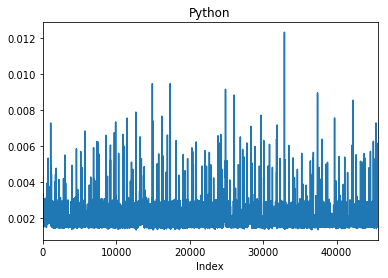

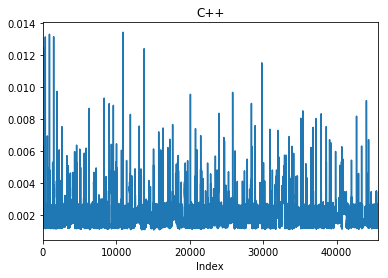

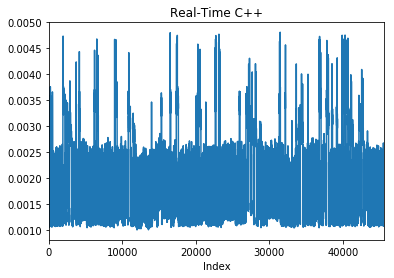

In [26]:
plt.figure(4)
dt_py.plot()
plt.title('Python')

plt.figure(5)
dt_cc.plot()
plt.title('C++')

plt.figure(6)
dt_rt.plot()
plt.title('Real-Time C++')

The time series give a better picture of the worst case scenario. The real-time optimized C++ implementation outshines the C++ and Python implementations that have very similar performance. What is not visible in these plots but that was evident during some of the testing that both the Python and the regular C++ implementation suffer from occasional peaks in the time series that are much worse than any of the visible values. This is because the operating system can take control from either of these processes to process some other tasks. The real-time C++ implementation can only be interrupted by hardware and real-time kernel tasks but not by other tasks in the operating system. 

## Steering Decisions

The timing results are only comparable if both inference implementations result in the same steering decisions.
To analyze this let's plot the outputs of the inference model as function of the images. We should expect the functions to look identical. 

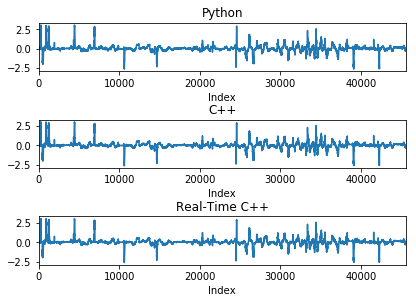

In [27]:
plt.figure(6)
plt.title('Steering action over time')
plt.subplot(311)
deg_py.plot()
plt.title('Python')
plt.subplot(312)
deg_cc.plot()
plt.title('C++')
plt.subplot(313)
deg_cc.plot()
plt.title('Real-Time C++')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1.0,
                    wspace=0.35)

From the above graphs it is clear that all models work identically or at least essentially identically and perform the same control decisions when provided the same data. This is what we would expect.

## Next Steps

Altough we implemented some real-time optimizations to the real-time C++ code, there are still many improvements that can be made to improve the time determinism of the real-time inference. Most importantly we currently read all the images from disk in the same loop as we perform the inference. Reading files from disk is not a time deterministic operation and adds uncontrolled jitter to the system. TensorFlow supports the concept of [input pipelines](https://www.tensorflow.org/programmers_guide/reading_data) that allow reading the files or hardware in one thread and processing it in another thread. This pipelined multi-threaded approach or something similar should be used for loading the data from files or hardware sensors to separate the data reading related jitter from the inference jitter and allowing the inference and reading to occur concurrently. Furthermore we didn't focus on CPU affinity at al in this project. We should assign specific real-time threads to specific CPUs to make sure they don't interfer with one another. For exampe reading files should occur on one CPU, managing the inference on another and interfacing the GPU on third. 

## Conclusions

When evaluating the performance of real-time control systems, it's important that the worst case delay is time bounded. Specifically it doesn't matter if self-driving car can make timely control decisions in 99.9% of the cases if in 0.1% of the cases the control decision takes much too long to make. Hence it's not sufficient to focus on mean execution time or even 90% percentile thereof. One has to focus on the worst case performance to determine safety of such real-time control system. Such worst-case execution guarantees can be provided by real-time operating systems. However even real-time operating system doesn't help if the applications are not designed to be real-time.

In this study we learned that a C++ implementation with basic real-time optimizations outperforms C++ and Python implementations when it comes to the worst-case execution times. The real-time C++ inference execution time stays below 5 ms throughout multiple experiments whereas the worst case execution times for regular C++ and Python implementations are between 10-15 ms.   

We naturally cannot make wide ranging recommensations only based on ~40k images fed through a very basic TensorFlow based self driving car steering model. When it comes to mean latency the three models perform almost equally. However the worst case performance of the real-time C++ model is much lower than the worst case performance of the regular C++ and Python models. However we don't have enough statistics to evaluate the real-world implications and we would need to run through much more data to make any statistically significant conclusions. 